In [1]:
using PyPlot

In [15]:
function plot_mapped_grid(R, n1, n2=n1)
    xy = Vector{Float64}[ R([ξ,η]) for ξ in (0:n1)./n1, η in (0:n2)./n2 ]
    x,y = first.(xy), last.(xy)
    plot(x, y, "k", x', y', "k", linewidth=1)
end

plot_mapped_grid (generic function with 2 methods)

In [87]:
A = 0.4
ybottom(x) = 64*A*x^3 * (1-x)^3
ytop(x) = 1 + A*x^3 * (6*x^2 - 15*x + 10) 

yderbottom(x) = 192*A*x^2 * (1-x)^3 - 192*A*x^3 * (1-x)^2
ydertop(x) = A * (30*x^4 - 60*x^3 + 30*x^2)

ydertop (generic function with 1 method)

In [88]:
function tfi_linear(ξη)

    # Boundaries
    left = [0, ξη[2]]
    right = [1, ξη[2]]
    bottom = [ξη[1], ybottom(ξη[1])]
    top = [ξη[1], ytop(ξη[1])]

    # Corners
    sw = [0, ybottom(0)] 
    nw = [0, ytop(0)]
    se = [1, ybottom(1)]
    ne = [1, ytop(1)]
    
    xy = (1-ξη[1]) * left + ξη[1] * right + (1 - ξη[2]) * bottom + ξη[2] * top 
        - (1-ξη[1]) * (1-ξη[2]) * sw - (1-ξη[1]) * ξη[2] * nw - ξη[1] * (1-ξη[2]) * se - ξη[1] * ξη[2] * ne
    return xy
end

tfi_linear (generic function with 1 method)

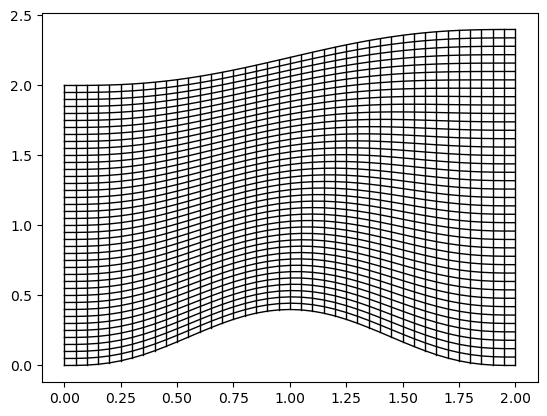

In [89]:
clf()
plot_mapped_grid(tfi_linear, 40)
gcf()

In [90]:
H0(η) = 2*η^3 - 3η^2 + 1
H1(η) = 3*η^2 - 2*η^3
H0_tilde(η) = η^3 - 2*η^2 + η
H1_tilde(η) = η^3 - η^2

H1_tilde (generic function with 1 method)

In [111]:
function tfi_orthogonal(ξη)
    T = 0.5
    # Boundaries
    bottom = [ξη[1], ybottom(ξη[1])]
    top = [ξη[1], ytop(ξη[1])]

    # Normal vectors 
    dx = 1
    dybottom = yderbottom(ξη[1])
    dytop = ydertop(ξη[1])
    nbottom = (1/sqrt(dybottom^2+dx^2)) .* [-dybottom, dx]
    ntop = (1/sqrt(dytop^2+dx^2)) .* [-dytop, dx]

    xy = @. bottom*H0(ξη[2]) + top*H1(ξη[2]) + T * (nbottom*H0_tilde(ξη[2]) + ntop*H1_tilde(ξη[2]))
    return xy
end

tfi_orthogonal (generic function with 1 method)

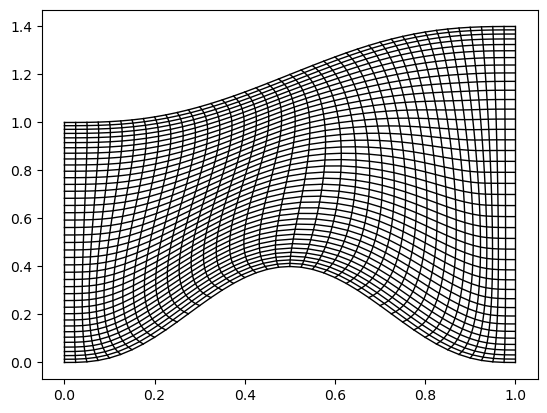

In [112]:
clf()
plot_mapped_grid(tfi_orthogonal, 40)
gcf()

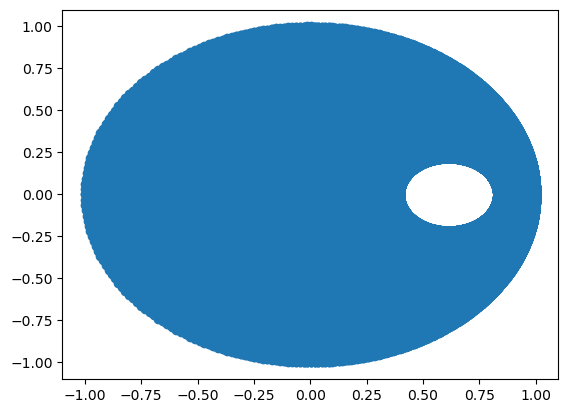

In [106]:
M = 1000
h = 1/M
x = (0:M)*h
y = (0:M)*h*2*pi

z = [xi + yi * 1im for yi=y, xi=x]

w = @. (2*exp(z) - 3) / (3*exp(z) - 2)
xi = real.(w)
eta = imag.(w)
clf()
scatter(xi, eta)
gcf()